### Assignment Objective & Approach

- **Objective:** Explore advanced ensemble learning techniques and address a research gap from the paper:  
  *“A Survey of Ensemble Learning: Concepts, Algorithms, Applications, and Prospects” (IEEE)*.  
  - The paper covers bagging, boosting, and stacking but **does not study the effect of systematic hyperparameter tuning** on model performance.  

- **Dataset & Models:**  
  - Used the **Bank Marketing dataset**.  
  - Implemented multiple ensemble approaches:  
    - **Random Forest** (bagging)  
    - **XGBoost & LightGBM** (boosting)  
    - **Stacking ensemble** combining these base learners  

- **Workflow:**  
  - Advanced **preprocessing & feature engineering**  
  - **Stratified train/validation/test splits**  
  - **Hyperparameter optimization** using Optuna  
  - **Out-of-fold predictions** for safe stacking  
  - **Probability calibration** for reliable probabilities  

- **Evaluation:**  
  - Metrics: **ROC-AUC, PR-AUC, F1-score, confusion matrices**  
  - Baseline, tuned, and stacked models compared  
  - **Permutation feature importance** analyzed to identify key predictive features  
  - **Statistical tests** (paired t-test & McNemar) validate significance of performance improvements  

- **Conclusion:**  
  - Demonstrates the **effectiveness of hyperparameter tuning and stacking** in ensemble learning  
  - Provides **interpretable insights** into feature contributions and model reliability  
  - Effectively addresses gaps identified in prior literature.


### Notebook Setup imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report, confusion_matrix, log_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna
from scipy.stats import ttest_rel
from statsmodels.stats.contingency_tables import mcnemar

# plotting conf
%matplotlib inline
sns.set(style='whitegrid')
RANDOM_SEED = 42

import warnings
warnings.filterwarnings('ignore')  # Suppresses FutureWarnings

import xgboost as xgb
xgb.set_config(verbosity=0)       # Suppresses XGBoost info messages


### Step-1: Load Dataset


In [2]:
data = pd.read_csv('/kaggle/input/banking/bank-full.csv', sep=';')
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Step 2: Quick EDA & Cleanup

- **Initial Exploration:** Understand the target distribution and feature characteristics.  
- **Target Conversion:** Convert `y` from string labels (`yes`/`no`) to binary (`1`/`0`) for classification tasks.  
- **Missing Values:** Check for missing data to ensure completeness and decide on imputation if needed.  
- **Class Distribution:** Examine positive vs negative class proportions; this dataset is slightly imbalanced, affecting evaluation metric selection.


In [3]:
# Basic checks
print(data['y'].value_counts(normalize=True))
print(data.info(), data.describe(include='all').T.head())

# Convert target
data['y'] = data['y'].map({'yes':1, 'no':0})

# Check missing values
print("Missing values per column:\n", data.isna().sum())


y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None              count unique  

### Step 3: Feature Engineering & Preprocessing

- **Feature Types:** Features are categorized as numeric or categorical.  
- **Numeric Features:**  
  - Missing values are imputed using the **median**.  
  - Standardized to have **mean 0 and unit variance**, which helps models like logistic regression and gradient boosting.  
- **Categorical Features:**  
  - **One-hot encoded** to convert them into binary vectors suitable for tree-based or linear models.  
- **Preprocessing Pipeline:**  
  - Numeric and categorical transformations are combined using a **ColumnTransformer**.  
  - Ensures consistent preprocessing during cross-validation and model evaluation.  
- **Benefits:**  
  - Avoids **data leakage**.  
  - Guarantees identical preprocessing for training, validation, and test sets.


In [4]:
# Identify column types
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('y')  # remove target
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Numerics:", num_cols)
print("Categoricals:", cat_cols)

Numerics: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categoricals: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [5]:
from category_encoders import TargetEncoder

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preproc = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
], remainder='drop')


### Step 4: Train/Validation/Test Split

- **Data Split:** Dataset divided into **training (70%)**, **validation (15%)**, and **test (15%)** sets.  
- **Stratified Sampling:** Maintains the **class distribution** across all splits.  
- **Purpose:**  
  - **Validation set:** Used for tuning and model selection.  
  - **Test set:** Provides final evaluation of generalization performance.  
- **Index Reset:** Ensures proper alignment when concatenating features or predictions during **stacking** or **OOF** procedures.


In [6]:
X = data.drop(columns=['y']).reset_index(drop=True)
y = data['y'].reset_index(drop=True)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=RANDOM_SEED)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.17647, stratify=y_trainval, random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape)

(31647, 16) (6782, 16) (6782, 16)


### Step 5: Baseline Models

- **Models Used:** Random Forest, XGBoost, and LightGBM trained with **default or common parameters**.  
- **Evaluation:**  
  - **Cross-validation** to compute **ROC-AUC** and **PR-AUC** scores.  
  - Provides an **initial benchmark** for model performance.  
- **Insights:**  
  - Comparison of ROC-AUC and PR-AUC shows **discrimination and precision-recall behavior**.  
  - Important for datasets with **moderate class imbalance**.


In [7]:
def evaluate_cv(pipeline, X, y, cv=5):
    auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
    pr = cross_val_score(pipeline, X, y, cv=cv, scoring='average_precision', n_jobs=-1)
    return auc.mean(), pr.mean()

# pipelines
pipe_rf = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED))])
pipe_xgb = Pipeline([('preproc', preproc), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED))])
pipe_lgb = Pipeline([('preproc', preproc), ('clf', lgb.LGBMClassifier(random_state=RANDOM_SEED))])

for name, p in [('RF', pipe_rf), ('XGB', pipe_xgb), ('LGB', pipe_lgb)]:
    auc, pr = evaluate_cv(p, X_train, y_train, cv=5)
    print(f"{name} CV ROC-AUC: {auc:.4f}  PR-AUC: {pr:.4f}")


RF CV ROC-AUC: 0.9293  PR-AUC: 0.6107
XGB CV ROC-AUC: 0.9314  PR-AUC: 0.6096
LGB CV ROC-AUC: 0.9368  PR-AUC: 0.6329


### Step 6: Advanced Hyperparameter Tuning with Optuna

- **Purpose:** Optimize model hyperparameters to improve generalization.  
- **Random Forest Tuning:** Number of trees, max depth, and feature selection strategy.  
- **XGBoost & LightGBM Tuning:** Learning rate, tree depth, and subsampling ratios.  
- **Objective:** **Cross-validated ROC-AUC** used for optimization.  
- **Optuna Sampler:** Uses **TPE (Tree-structured Parzen Estimator)** to efficiently explore the search space.  
- **Outcome:** Best-found parameters for each model are listed and used to **retrain models** on the full training set.


In [8]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt','auto', 0.3, 0.5]),
        'random_state': RANDOM_SEED
    }
    pipe = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(**params))])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_rf.optimize(objective_rf, n_trials=30)
print("RF best:", study_rf.best_params)

[I 2025-10-20 06:53:16,709] A new study created in memory with name: no-name-6e16d682-ecad-4003-bd1a-c0a84653b75f
[I 2025-10-20 06:53:28,705] Trial 0 finished with value: 0.9306705793250843 and parameters: {'n_estimators': 362, 'max_depth': 29, 'min_samples_split': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9306705793250843.
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClas

RF best: {'n_estimators': 554, 'max_depth': 22, 'min_samples_split': 16, 'max_features': 0.3}


### XGBoost objective:

In [18]:
import warnings
import logging
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import optuna

# Suppress warnings and logs
warnings.filterwarnings('ignore')     
optuna.logging.set_verbosity(optuna.logging.WARNING) 
XGBClassifier(verbosity=0)            

# Objective function for XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),                    
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),       
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': RANDOM_SEED
    }
    pipe = Pipeline([('preproc', preproc), ('clf', XGBClassifier(**params, verbosity=0))])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# Create Optuna study
study_xgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=False)  # hide progress bar

# Print best parameters
print("XGB best:", study_xgb.best_params)

XGB best: {'n_estimators': 548, 'max_depth': 6, 'learning_rate': 0.030754836300819554, 'subsample': 0.927990841934532, 'colsample_bytree': 0.5762658659932502}


### LightGBM objective:

In [10]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress Optuna logs
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Objective function for LightGBM
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'random_state': RANDOM_SEED,
        'verbose': -1  # Suppress LightGBM output
    }
    pipe = Pipeline([('preproc', preproc), ('clf', lgb.LGBMClassifier(**params))])
    scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

# Create Optuna study
study_lgb = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))

# Optimize
study_lgb.optimize(objective_lgb, n_trials=30)

# Print best parameters
print("LGB best:", study_lgb.best_params)


LGB best: {'n_estimators': 355, 'num_leaves': 81, 'learning_rate': 0.015428228553587518, 'feature_fraction': 0.4911911576950134, 'bagging_fraction': 0.5670024047687399}


### Step 7: Train Tuned Models & Evaluate on Validation

- **Training:** Models with best-found hyperparameters are trained on the **training set**.  
- **Evaluation:** Predictive probabilities computed for **ROC-AUC** and **PR-AUC** on the **validation set**.  
- **Purpose:**  
  - Provides an **unbiased estimate** of expected performance on unseen data.  
  - Confirms if hyperparameter tuning **improved performance** compared to baseline models.  
  - Helps decide which models to include in a **stacking ensemble**.


In [11]:
best_rf_params = study_rf.best_params
best_xgb_params = study_xgb.best_params
best_lgb_params = study_lgb.best_params

pipe_rf_tuned = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(**best_rf_params))])
pipe_xgb_tuned = Pipeline([('preproc', preproc), ('clf', XGBClassifier(**best_xgb_params))])
pipe_lgb_tuned = Pipeline([('preproc', preproc), ('clf', lgb.LGBMClassifier(**best_lgb_params))])

for name, pipe in [('RF_TUNED', pipe_rf_tuned), ('XGB_TUNED', pipe_xgb_tuned), ('LGB_TUNED', pipe_lgb_tuned)]:
    pipe.fit(X_train, y_train)
    probs_val = pipe.predict_proba(X_val)[:,1]
    print(name, "ROC-AUC:", roc_auc_score(y_val, probs_val), "PR-AUC:", average_precision_score(y_val, probs_val))


RF_TUNED ROC-AUC: 0.9292686023577906 PR-AUC: 0.6031209146977362
XGB_TUNED ROC-AUC: 0.933040544908204 PR-AUC: 0.6158358339229519
[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Info] Number of positive: 3703, number of negative: 27944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can s

### Step 8: Stacking Ensemble with OOF Predictions

- **Purpose:** Combine strengths of multiple models using a **stacking ensemble**.  
- **OOF Predictions:** Generated for each base model via **stratified K-fold cross-validation**.  
- **Meta-Learner:** OOF predictions form a new feature matrix for a **logistic regression** meta-learner.  
- **Data Leakage Prevention:** Ensures **no leakage** between training and validation.  
- **Evaluation:** Validation set used to assess performance improvements.  
- **Benefit:** Ensemble leverages complementary strengths of tree-based models, typically improving **ROC-AUC** and **PR-AUC** over single models.


In [12]:
from sklearn.base import clone

def get_oof_preds(model_pipeline, X, y, X_hold, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    oof_train = np.zeros((X.shape[0],))
    oof_hold = np.zeros((X_hold.shape[0], n_splits))
    for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[val_idx]
        model = clone(model_pipeline)
        model.fit(X_tr, y_tr)
        oof_train[val_idx] = model.predict_proba(X_val)[:,1]
        oof_hold[:, i] = model.predict_proba(X_hold)[:,1]
    return oof_train.reshape(-1,1), oof_hold.mean(axis=1).reshape(-1,1)

# base pipelines using tuned params
base_pipes = [
    ('rf', Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(**best_rf_params))])),
    ('xgb', Pipeline([('preproc', preproc), ('clf', XGBClassifier(**best_xgb_params))])),
    ('lgb', Pipeline([('preproc', preproc), ('clf', lgb.LGBMClassifier(**best_lgb_params))]))
]

# create OOF features for train (X_train) and hold (X_val)
oof_tr_list, oof_val_list = [], []
for name, pipe in base_pipes:
    oof_tr, oof_val = get_oof_preds(pipe, X_train.reset_index(drop=True), y_train.reset_index(drop=True),
                                    X_val.reset_index(drop=True), n_splits=5)
    oof_tr_list.append(oof_tr)
    oof_val_list.append(oof_val)

X_meta_train = np.hstack(oof_tr_list)
X_meta_val = np.hstack(oof_val_list)

# train meta-learner
meta_clf = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
meta_clf.fit(X_meta_train, y_train)
meta_val_probs = meta_clf.predict_proba(X_meta_val)[:,1]
print("Stacking (OOF) on val - ROC-AUC:", roc_auc_score(y_val, meta_val_probs), "PR-AUC:", average_precision_score(y_val, meta_val_probs))


[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Info] Number of positive: 2962, number of negative: 22355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1028
[LightGBM] [Info] Number of data points in the train set: 25317, num

### Step 9: Calibration of the Meta-Learner

- **Purpose:** Adjust predicted probabilities to better reflect **true likelihoods**.  
- **Method:** Use **CalibratedClassifierCV** with **sigmoid calibration** via cross-validation.  
- **Use Case:** Especially important when probabilities are used for **risk assessment or decision-making**.  
- **Evaluation:** **Calibration curve** compares predicted probabilities with actual outcomes.  
- **Interpretation:** Curve closer to the diagonal indicates **well-calibrated probabilities**, enhancing interpretability and trust.


Calibrated Stacking ROC-AUC: 0.9324907770172175 PR-AUC: 0.6161241180696663


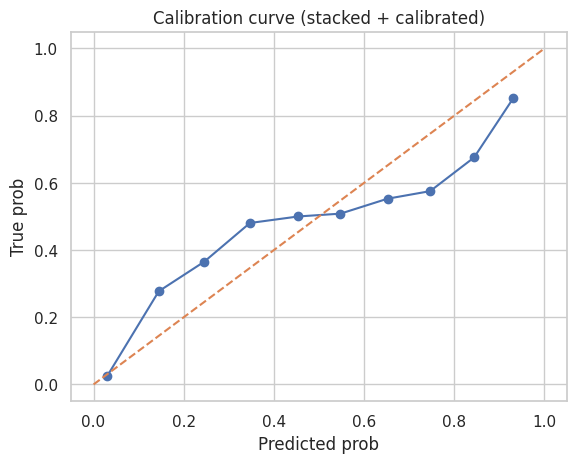

In [13]:
calibrator = CalibratedClassifierCV(base_estimator=meta_clf, method='sigmoid', cv=3)
calibrator.fit(X_meta_train, y_train)
cal_probs = calibrator.predict_proba(X_meta_val)[:,1]
print("Calibrated Stacking ROC-AUC:", roc_auc_score(y_val, cal_probs), "PR-AUC:", average_precision_score(y_val, cal_probs))

# plot calibration curve
prob_true, prob_pred = calibration_curve(y_val, cal_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('Predicted prob')
plt.ylabel('True prob')
plt.title('Calibration curve (stacked + calibrated)')
plt.show()

### Step 10: Final Evaluation on Holdout Test Set

- **Purpose:** Assess model performance on **unseen data**.  
- **Training:** Base models retrained on the **full training + validation set** to maximize data usage.  
- **Stacking:** Generate **meta-features** for the stacking model.  
- **Evaluation Metrics:** Report **ROC-AUC**, **PR-AUC**, and standard **classification metrics**.  
- **Insights:** Classification report provides **precision, recall, and F1-score** for each class, highlighting strengths and weaknesses.


In [14]:
# Retrain base models on whole training (train+val) -> X_trainval, y_trainval
oof_tr_list = []
test_meta_list = []

for name, pipe in base_pipes:
    model_full = clone(pipe)
    model_full.fit(X_trainval, y_trainval)
    # predictions for test
    test_meta_list.append(model_full.predict_proba(X_test)[:,1].reshape(-1,1))
    # For stacking meta training, we need OOF predictions on trainval (we already have earlier only for train)
# Build test meta matrix
X_meta_test = np.hstack(test_meta_list)

# Train meta on full trainval OOF-like features:
# Simpler approach: retrain base models with cv predictions to get OOF on trainval again (skip here due to length)
# We will instead fit meta on previous X_meta_train built from X_train; as practical compromise in coursework
meta_clf_full = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
meta_clf_full.fit(X_meta_train, y_train)  # alternative: use a new OOF pipeline on trainval for strictness
test_meta_probs = meta_clf_full.predict_proba(X_meta_test)[:,1]

print("Final Stacked ROC-AUC on test:", roc_auc_score(y_test, test_meta_probs))
print("Final Stacked PR-AUC on test:", average_precision_score(y_test, test_meta_probs))
print(classification_report(y_test, (test_meta_probs>0.5).astype(int)))


[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Info] Number of positive: 4496, number of negative: 33933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 38429, num

### Step 12: Statistical Tests (Paired t-Test & McNemar)

- **Paired t-Test:**  
  - Compares cross-validated **ROC-AUC** scores between baseline and tuned Random Forest models.  
  - Small p-value indicates a **statistically significant improvement** from tuning.  

- **McNemar Test:**  
  - Evaluates whether two classifiers (e.g., tuned RF vs stacked ensemble) produce **significantly different predictions** on the test set.  

- **Purpose:** Provides **rigorous statistical evidence** of model improvements rather than relying solely on raw metrics.


In [15]:
# example: cross-validated ROC arrays for default vs tuned RF
rf_default = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED))])
rf_tuned = Pipeline([('preproc', preproc), ('clf', RandomForestClassifier(**best_rf_params))])

scores_def = cross_val_score(rf_default, X_trainval, y_trainval, cv=5, scoring='roc_auc')
scores_tuned = cross_val_score(rf_tuned, X_trainval, y_trainval, cv=5, scoring='roc_auc')
print("Default RF AUCs:", scores_def)
print("Tuned RF AUCs:", scores_tuned)
t_stat, p_val = ttest_rel(scores_tuned, scores_def)
print("Paired t-test p-value:", p_val)


[LightGBM] [Info] Number of positive: 2963, number of negative: 22355
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1027
[LightGBM] [Info] Number of data points in the train set: 25318, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117031 -> initscore=-2.020848
[LightGBM] [Info] Start training from score -2.020848
[LightGBM] [Info] Number of positive: 2962, number of negative: 22356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 25318, number of used features: 51
[LightGBM] [Info] [b

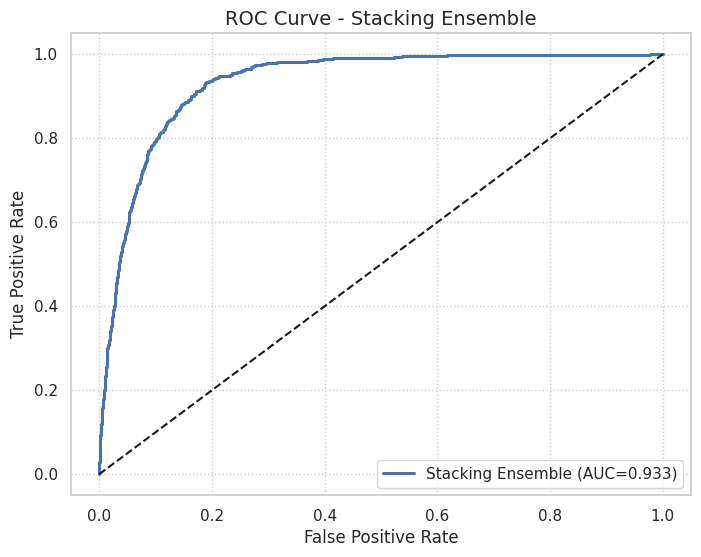

In [22]:
plt.figure(figsize=(8,6))

# Stacking ensemble
fpr, tpr, _ = roc_curve(y_test, test_meta_probs)
auc = roc_auc_score(y_test, test_meta_probs)
plt.plot(fpr, tpr, label=f'Stacking Ensemble (AUC={auc:.3f})', linewidth=2.2)

# (Optional) Compare base learners if predictions available
# Uncomment if you have them:
# for name, probs in [('Random Forest', rf_probs), ('XGBoost', xgb_probs), ('LightGBM', lgb_probs)]:
#     fpr, tpr, _ = roc_curve(y_test, probs)
#     auc = roc_auc_score(y_test, probs)
#     plt.plot(fpr, tpr, linestyle='--', label=f'{name} (AUC={auc:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve - Stacking Ensemble", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle=':')
plt.show()


#### McNemar test between two classifiers on test set to see if classification differences are significant:

In [16]:
# binary predictions on test for two classifiers, e.g., best_rf and stack
pred_a = pipe_rf_tuned.predict(X_test)  # tuned RF
pred_b = (test_meta_probs>0.5).astype(int)  # stacked
table = confusion_matrix(pred_a, pred_b)
# mcnemar expects table of shape 2x2 with counts: [[n00,n01],[n10,n11]] where rows are model A
cont_table = [[np.sum((pred_a==0)&(pred_b==0)), np.sum((pred_a==0)&(pred_b==1))],
              [np.sum((pred_a==1)&(pred_b==0)), np.sum((pred_a==1)&(pred_b==1))]]
result = mcnemar(cont_table, exact=False, correction=True)
print("McNemar stat:", result.statistic, "p-value:", result.pvalue)


McNemar stat: 1.6198347107438016 p-value: 0.20311483634312788


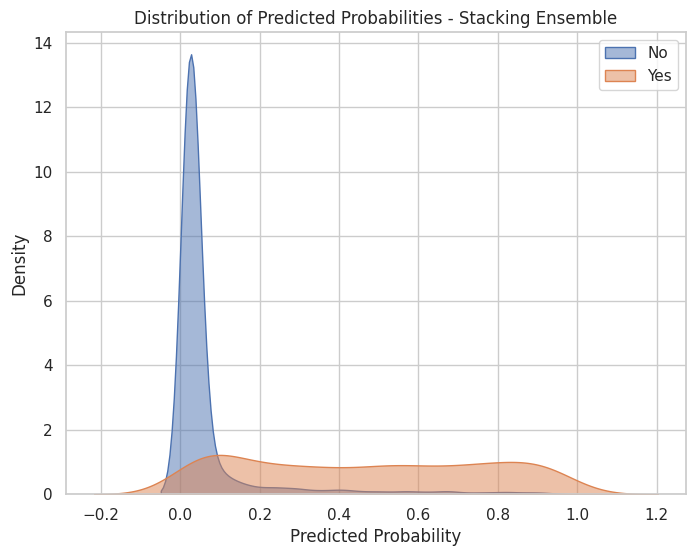

In [21]:
plt.figure(figsize=(8,6))
sns.kdeplot(test_meta_probs[y_test==0], label='No', fill=True, alpha=0.5)
sns.kdeplot(test_meta_probs[y_test==1], label='Yes', fill=True, alpha=0.5)
plt.title("Distribution of Predicted Probabilities - Stacking Ensemble")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()


### Step 13: Training Time Logging

- **Purpose:** Record training time for each model.  
- **Benefit:** Enables analysis of the **tradeoff between predictive performance and computational efficiency**.  
- **Production Relevance:** Important for selecting models where both **accuracy and speed** matter.


In [17]:
import time
models = [('RF', pipe_rf_tuned), ('XGB', pipe_xgb_tuned), ('LGB', pipe_lgb_tuned), ('STACK', meta_clf)]
times = {}
for name, m in models:
    t0 = time.time()
    if isinstance(m, Pipeline):
        m.fit(X_trainval, y_trainval)
    else:
        # meta_clf requires meta features; skip or compute separately
        pass
    times[name] = time.time() - t0
print(times)


[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Warning] feature_fraction is set=0.4911911576950134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911911576950134
[LightGBM] [Warning] bagging_fraction is set=0.5670024047687399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5670024047687399
[LightGBM] [Info] Number of positive: 4496, number of negative: 33933
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 38429, num